In [1]:
!pip3 install pyro-ppl
!pip3 install sklearn
!pip3 install arviz
!pip3 install numpy
!pip3 install matplotlib

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


/usr/local/lib/python3.10/dist-packages/pyro/infer/mcmc/api.py:499: UserWarning: num_chains=2 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(


MAP Optimized Lengthscale: 0.3484484851360321
MAP Optimized Variance: 2.239685535430908
Posterior Log-Likelihood (MAP) on Test Set: 15.653841018676758
Available CPU cores: 2


Sample [1]: 100%|██████████| 2300/2300 [01:11, 32.36it/s, step size=6.13e-01, acc. prob=0.948]


Autocorrelation Plot:


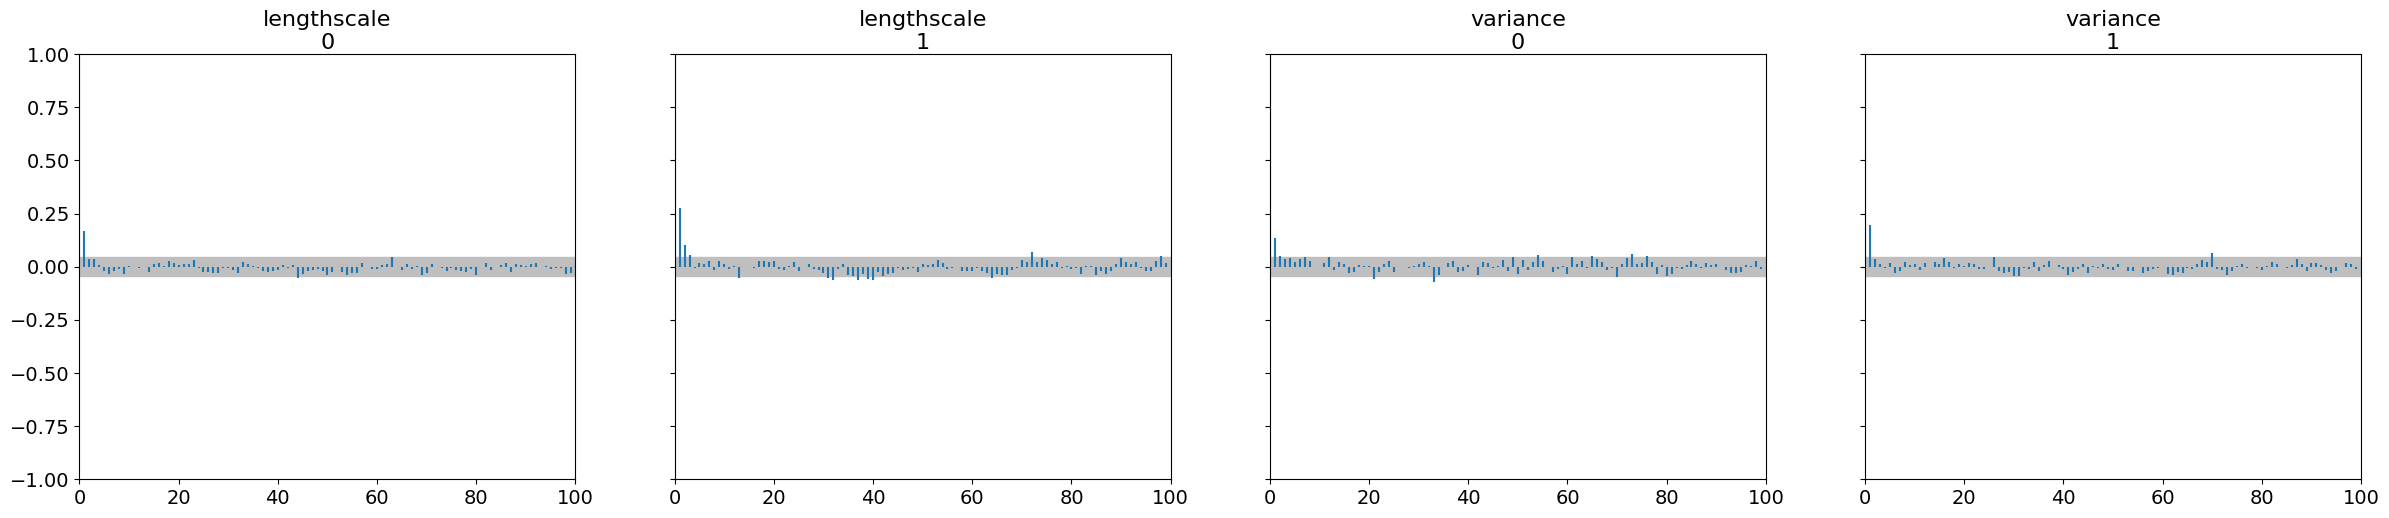

R-hat Diagnostic:
              mean  r_hat  ess_bulk  ess_tail
lengthscale  1.960    1.0    1954.0    1372.0
variance     2.017    1.0    1991.0    1977.0
Number of Divergences: 0
No divergences detected. Sampling appears stable.


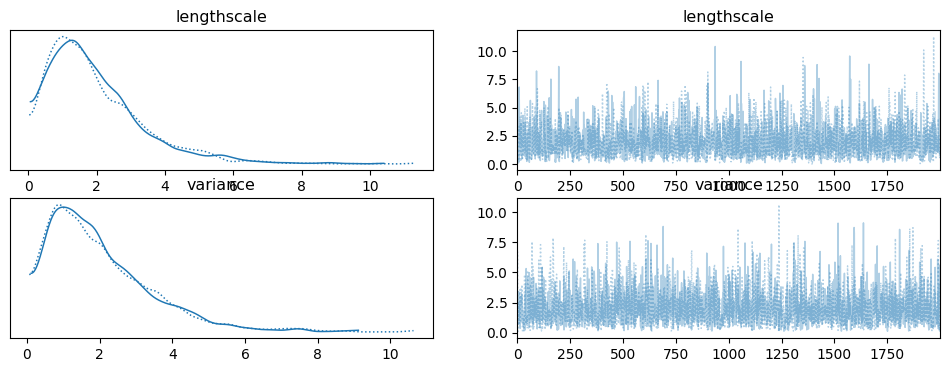

              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
lengthscale  1.960  1.389   0.101    4.547      0.028     0.02    1954.0   
variance     2.017  1.432   0.103    4.544      0.029     0.02    1991.0   

             ess_tail  r_hat  
lengthscale    1372.0    1.0  
variance       1977.0    1.0  


Processing 20 datasets:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/infer/mcmc/api.py:499: UserWarning: num_chains=2 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(
Processing 20 datasets: 100%|██████████| 20/20 [16:17<00:00, 48.89s/it]


MAP Optimized Lengthscales: [0.3781884014606476, 0.30773937702178955, 0.3754577338695526, 0.39437270164489746, 0.3763958513736725, 0.3819461166858673, 0.38526004552841187, 0.3564126789569855, 0.3723098933696747, 0.3840198814868927, 0.35580697655677795, 0.3826998472213745, 0.3937127888202667, 0.3853429853916168, 0.4066314101219177, 0.33779850602149963, 0.37918251752853394, 0.3264531195163727, 0.3156353533267975, 0.3180968463420868]
MAP Optimized Variances: [2.249934434890747, 1.0452545881271362, 2.267773151397705, 3.2484569549560547, 2.225438117980957, 2.5287604331970215, 2.5087056159973145, 2.0279722213745117, 2.5030248165130615, 2.619293689727783, 1.9809859991073608, 2.480957269668579, 2.6739845275878906, 2.5166056156158447, 3.2125515937805176, 1.4458441734313965, 2.45511794090271, 1.4924638271331787, 1.281006097793579, 1.2626327276229858]
NUTS Optimized Lengthscales: [1.5119667053222656, 1.4640196561813354, 0.9796191453933716, 2.261561870574951, 0.10436038672924042, 0.570682227611541

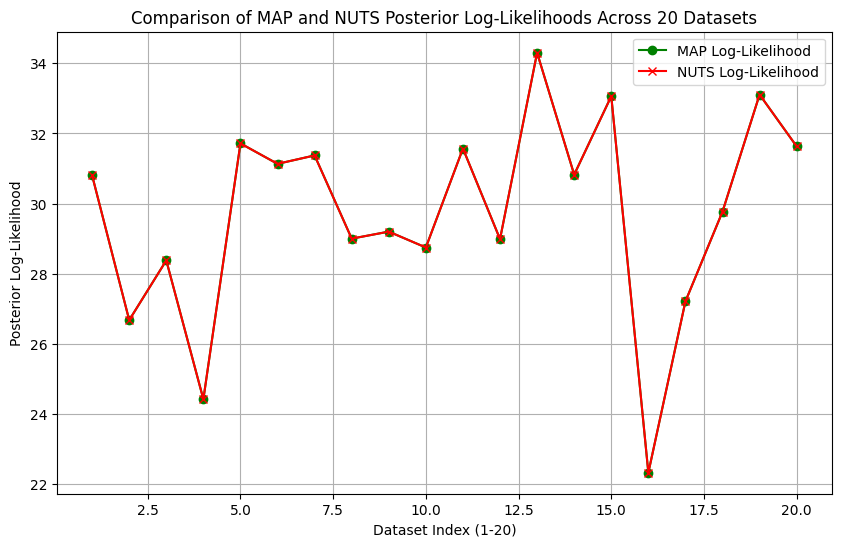

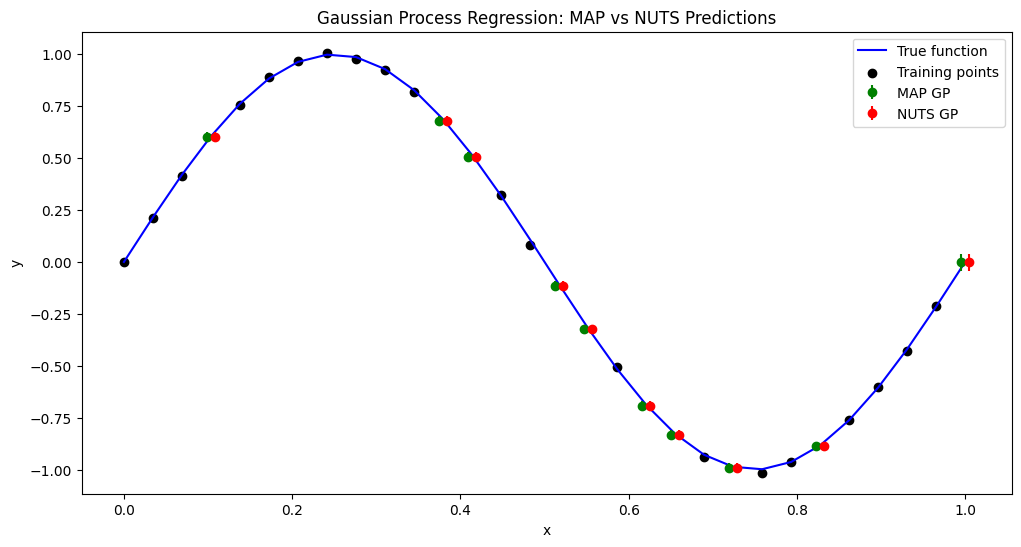

In [2]:
import numpy as np
import torch
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
from tqdm import tqdm
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import matplotlib.pyplot as plt
import arviz as az

# Clear Pyro's parameter store to avoid parameter accumulation.
pyro.clear_param_store()


# Seed for reproducibility.
np.random.seed(42)
torch.manual_seed(42)

# Step 1: Generate synthetic dataset
# ----------------------------------
l = 30
x = torch.linspace(0, 1, l)  # Input grid points.
true_function = lambda x: torch.sin(2 * torch.pi * x)  # True function: sine wave
y = true_function(x) + torch.normal(0, 0.01, size=(l,))

# Split data into training and testing sets.
indices = np.random.permutation(l)
train_idx, test_idx = indices[:20], indices[20:]
train_x, test_x = x[train_idx], x[test_idx]
train_y, test_y = y[train_idx], y[test_idx]

# Step 2: Define reusable functions.
# ---------------------------------

# Function to train MAP GP model.
def train_map_gp(train_x, train_y, test_x, noise=0.01, num_steps=500, lr=0.01):
    kernel = gp.kernels.RBF(input_dim=1)
    map_gp = gp.models.GPRegression(train_x, train_y, kernel, noise=torch.tensor(noise))
    optimizer = Adam({"lr": lr})
    svi = SVI(map_gp.model, map_gp.guide, optimizer, loss=Trace_ELBO())
    for step in range(num_steps):
        svi.step()
    map_mean, map_var = map_gp(test_x, full_cov=False, noiseless=False)
    return map_mean, map_var, map_gp

# Function to generate a new dataset.
def generate_dataset(l=30):
    x = torch.linspace(0, 1, l)
    y = true_function(x) + torch.normal(0, 0.01, size=(l,))
    indices = np.random.permutation(l)
    train_idx, test_idx = indices[:20], indices[20:]
    return x, train_x, test_x, train_y, test_y

# Initial MAP Training.
map_mean, map_var, map_gp = train_map_gp(train_x, train_y, test_x)

# Extract and print optimized MAP hyperparameters.
optimized_lengthscale = map_gp.kernel.lengthscale.detach().item()
optimized_variance = map_gp.kernel.variance.detach().item()
print(f"MAP Optimized Lengthscale: {optimized_lengthscale}")
print(f"MAP Optimized Variance: {optimized_variance}")

# Step 3: Compute posterior log-likelihood for MAP.
with torch.no_grad():
    log_likelihood_map = -0.5 * ((test_y - map_mean) ** 2 / map_var + torch.log(2 * torch.pi * map_var)).sum()
    print(f"Posterior Log-Likelihood (MAP) on Test Set: {log_likelihood_map.item()}")

# Step 4: Define probabilistic model for NUTS.
# -------------------------------------------
def model():
    # Defining a new kernel instance for each run to avoid shared state.
    kernel = gp.kernels.RBF(input_dim=1)
    lengthscale = pyro.sample("lengthscale", dist.Gamma(2.0, 1.0))
    variance = pyro.sample("variance", dist.Gamma(2.0, 1.0))
    kernel.lengthscale = lengthscale
    kernel.variance = variance
    gp_model = gp.models.GPRegression(train_x, train_y, kernel, noise=torch.tensor(0.01))
    gp_model.model()

# Step 5: Core check.
import multiprocessing  # For detecting CPU cores.

# Detect number of available CPU cores.
available_cores = multiprocessing.cpu_count()
print(f"Available CPU cores: {available_cores}")

num_chains = 2

#Run of the first MCMC outside of the 20-dataset loop.
# ---------------------
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=300, num_chains=num_chains)
mcmc.run()

# Extract samples.
posterior_samples = mcmc.get_samples()
lengthscale_samples = posterior_samples["lengthscale"]
variance_samples = posterior_samples["variance"]

# Step 6: ArviZ Diagnostics.
# -------------------------
  # This section performs diagnostics on the NUTS sampling to evaluate the quality of the posterior samples.
# -------------------------

# Convert MCMC results to InferenceData for diagnostics
idata = az.from_pyro(mcmc, posterior_predictive=None)
# Autocorrelation Check
  # Measures how correlated the MCMC samples are over different lags.
  # High autocorrelation indicates poor mixing, while low suggests efficient sampling. Also we want a steep decrese
print("Autocorrelation Plot:")
az.plot_autocorr(idata)
plt.show()

# R-hat Diagnostic (also called Convergence)
  # Evaluates whether multiple MCMC chains have converged.
  # R-hat values close to 1.0 indicate good convergence.
summary = az.summary(idata)
print("R-hat Diagnostic:")
print(summary[["mean", "r_hat", "ess_bulk", "ess_tail"]])

# Divergences Check
  # Counts the number of divergences during NUTS sampling.
  # Divergences may signal sampling issues related to model geometry.
num_divergences = idata.sample_stats["diverging"].sum().item()
print(f"Number of Divergences: {num_divergences}")
if num_divergences == 0:
    print("No divergences detected. Sampling appears stable.")
else:
    print("Warning: Divergences detected. Consider tuning hyperparameters.")

az.plot_trace(idata)
plt.show()

summary = az.summary(idata)
print(summary)

# Step 7: Predictive Model Using NUTS Samples.
# ------------------------------------------

# Preserve the original training and test data.
orig_train_x, orig_train_y, orig_test_x, orig_test_y = train_x.clone(), train_y.clone(), test_x.clone(), test_y.clone()

# Define the kernel for the NUTS GP model.
kernel = gp.kernels.RBF(input_dim=1)

# Check if posterior samples are available.
if len(lengthscale_samples) > 0 and len(variance_samples) > 0:

# Uses the posterior mean of the NUTS-sampled hyperparameters to make predictions on the test set.
# ------------------------------------------
    posterior_mode_lengthscale = lengthscale_samples.mode()[0]
    posterior_mode_variance = variance_samples.mode()[0]
    kernel.lengthscale = posterior_mode_lengthscale
    kernel.variance = posterior_mode_variance

    # Define NUTS GP model with preserved data.
    nuts_gp = gp.models.GPRegression(orig_train_x, orig_train_y, kernel, noise=torch.tensor(0.01))
    nuts_mean, nuts_var = nuts_gp(orig_test_x, full_cov=False, noiseless=False)
else:
    print("Warning: Posterior samples are empty. NUTS predictions cannot be computed.")

# Step 8: Evaluation Over Multiple Datasets.
# -----------------------------------------

# Function to compute log-likelihood.
def compute_log_likelihood(y_true, mean, var):
    return -0.5 * ((y_true - mean) ** 2 / var + torch.log(2 * torch.pi * var)).sum().item()

# Here we store the results for plots
map_log_likelihoods = []
nuts_log_likelihoods = []  # For NUTS log-likelihoods

# Storing the hyperparameters for comparing.
map_lengthscales = []
map_variances = []
nuts_lengthscales = []
nuts_variances = []  # For NUTS log-likelihoods

# Retering the two process for 20 datasets
for run in tqdm(range(20), desc="Processing 20 datasets"):
    # Generats new dataset
    y = true_function(x) + torch.normal(0, 0.01, size=(l,))
    indices = np.random.permutation(l)
    train_idx, test_idx = indices[:20], indices[20:]
    train_x, test_x = x[train_idx], x[test_idx]
    train_y, test_y = y[train_idx], y[test_idx]

        # --- MAP Estimation ---
    map_mean, map_var, map_gp = train_map_gp(train_x, train_y, test_x)
    map_log_likelihoods.append(compute_log_likelihood(test_y, map_mean, map_var))

    # Store MAP hyperparameters
    map_lengthscales.append(map_gp.kernel.lengthscale.detach().item())
    map_variances.append(map_gp.kernel.variance.detach().item())

    # --- NUTS Sampling ---
    def model():
        kernel = gp.kernels.RBF(input_dim=1)
        lengthscale = pyro.sample("lengthscale", dist.Gamma(2.0, 1.0))
        variance = pyro.sample("variance", dist.Gamma(2.0, 1.0))
        kernel.lengthscale = lengthscale
        kernel.variance = variance
        gp_model = gp.models.GPRegression(train_x, train_y, kernel, noise=torch.tensor(0.01))
        gp_model.model()

    nuts_kernel = NUTS(model, jit_compile=False)
    mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=300, num_chains=num_chains)
    mcmc.run()

    posterior_samples = mcmc.get_samples()
    posterior_mode_lengthscale = posterior_samples['lengthscale'].mode()[0]
    posterior_mode_variance = posterior_samples['variance'].mode()[0]

    kernel = gp.kernels.RBF(input_dim=1)
    kernel.lengthscale = posterior_mode_lengthscale
    kernel.variance = posterior_mode_variance

    nuts_gp = gp.models.GPRegression(train_x, train_y, kernel, noise=torch.tensor(0.01))
    nuts_mean, nuts_var = nuts_gp(test_x, full_cov=False, noiseless=False)
    nuts_log_likelihoods.append(compute_log_likelihood(test_y, nuts_mean, nuts_var))

    # Store NUTS hyperparameters
    nuts_lengthscales.append(posterior_mode_lengthscale.detach().item())
    nuts_variances.append(posterior_mode_variance.detach().item())



# Step 9: Comparison Printing and mean/std calculation.
# ------------------------
# Calculate mean and standard deviation of log-likelihoods
map_mean_ll = np.mean(map_log_likelihoods)
map_std_ll = np.std(map_log_likelihoods)
nuts_mean_ll = np.mean(nuts_log_likelihoods)
nuts_std_ll = np.std(nuts_log_likelihoods)

# Print summary statistics for comparison
# Print MAP and NUTS hyperparameters
print("MAP Optimized Lengthscales:", map_lengthscales)
print("MAP Optimized Variances:", map_variances)
print("NUTS Optimized Lengthscales:", nuts_lengthscales)
print("NUTS Optimized Variances:", nuts_variances)
print(f"MAP Log-Likelihood Mean: {map_mean_ll:.4f}, Std: {map_std_ll:.4f}")
print(f"NUTS Log-Likelihood Mean: {nuts_mean_ll:.4f}, Std: {nuts_std_ll:.4f}")


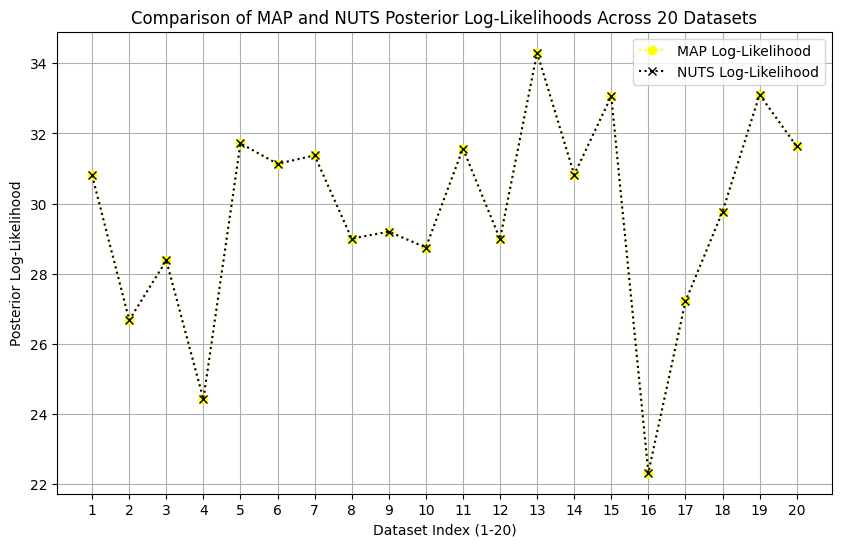

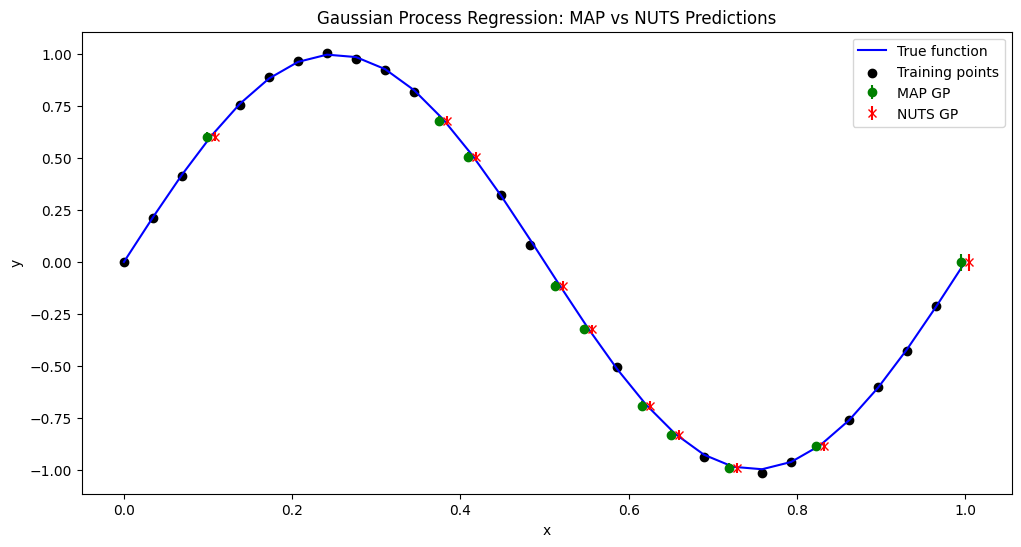

In [18]:
# Step 10: Plots for Comparison.
# ------------------------
  # Log-likelihood.
model_number = np.linspace(1,20,20)
plt.figure(figsize=(10, 6))
plt.plot(model_number, map_log_likelihoods, label='MAP Log-Likelihood',linestyle='dotted', marker='o', color='yellow')
plt.plot(model_number, nuts_log_likelihoods, label='NUTS Log-Likelihood',linestyle='dotted', marker='x', color='black')
plt.xlabel('Dataset Index (1-20)')
plt.ylabel('Posterior Log-Likelihood')
plt.title('Comparison of MAP and NUTS Posterior Log-Likelihoods Across 20 Datasets')
plt.legend()
plt.xticks(model_number)
plt.grid(True)
plt.show()
# ---------------------
  # GP predictions.
plt.figure(figsize=(12, 6))
plt.plot(x, true_function(x), label="True function", color="blue")
plt.scatter(train_x, train_y, label="Training points", color="black")
plt.errorbar(test_x - 0.005, map_mean.detach().numpy(), yerr=2*np.sqrt(map_var.detach().numpy()), fmt='o', label="MAP GP", color="green")
plt.errorbar(test_x + 0.005, nuts_mean.detach().numpy(), yerr=2*np.sqrt(nuts_var.detach().numpy()), fmt='x', label="NUTS GP", color="red")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Gaussian Process Regression: MAP vs NUTS Predictions")
plt.show()